In [1]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.model_selection
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
%matplotlib inline

C:\Users\Yiheng\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [168]:
data = pd.read_csv("data.csv",sep=",")
print(data.shape)
print data.info()

(41188, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
ind               41188 non-null int64
age               41188 non-null int64
job               40858 non-null object
marital           41108 non-null object
education         39457 non-null object
default           32591 non-null object
housing           40198 non-null object
loan              40198 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          5625 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
d

In [169]:
# # drop observations with missing data
# data["poutcome"]=data["poutcome"].fillna("nonexistent") # most value of "poutcome" are missing, keep them
# data=data.dropna(how='any')

### 若做 matrix completion 则
data["poutcome"]=data["poutcome"].fillna("nonexistent") # most value of "poutcome" are missing, keep them
data["default"]=data["default"].fillna("nonexistent") # most value of "default" are missing, keep them
data=data.dropna(how='any')
print data.info()
# data["poutcome"]=data["poutcome"].fillna("nonexistent") # most value of "poutcome" are missing, keep them
# data["default"]=data["default"].fillna("nonexistent") # most value of "default" are missing, keep them

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38245 entries, 0 to 41187
Data columns (total 22 columns):
ind               38245 non-null int64
age               38245 non-null int64
job               38245 non-null object
marital           38245 non-null object
education         38245 non-null object
default           38245 non-null object
housing           38245 non-null object
loan              38245 non-null object
contact           38245 non-null object
month             38245 non-null object
day_of_week       38245 non-null object
duration          38245 non-null int64
campaign          38245 non-null int64
pdays             38245 non-null int64
previous          38245 non-null int64
poutcome          38245 non-null object
emp.var.rate      38245 non-null float64
cons.price.idx    38245 non-null float64
cons.conf.idx     38245 non-null float64
euribor3m         38245 non-null float64
nr.employed       38245 non-null float64
y                 38245 non-null object
dtypes: floa

In [133]:
data["job"][0]

'housemaid'

## corr plot

In [153]:
corr_graph = pd.read_csv("clean_data_corr.csv",sep=",")

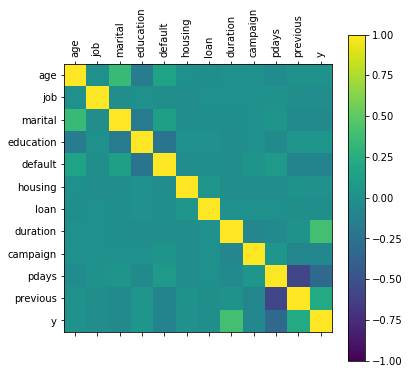

In [167]:
# plot correlation matrix
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
cax = ax.matshow(corr_graph.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,12,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_graph.columns.values,rotation=90)
ax.set_yticklabels(corr_graph.columns.values) 
plt.show()

## one-hot encode

In [170]:
#Pre Condition: One Hot encode
def one_hot_encode(data,column_name,index_name):
    n = data.shape[0] #length of columns 
    binary_data = pd.DataFrame() #new dataframe to store cleaned data
    old_row = data[column_name]
    UniqueVal=[]
    for elem in old_row:       
        if not elem in UniqueVal:
            UniqueVal.append(elem)
    #creates new columns out of entries of old column
    for new_col in UniqueVal:        
        #if new_col=="nonexistent":
        if column_name=="poutcome":
            #print ("poutcome."+new_col)
            if new_col=="failure":
                continue
            binary_data["poutcome."+new_col] = (old_row==new_col)+0.0
        elif column_name=="default":
            if new_col=="no":
                continue
            binary_data["default."+new_col] = (old_row==new_col)+0.0
        else:
            binary_data[new_col] = (old_row==new_col)+0.0
    
    binary_data[index_name]=data[index_name]
    return binary_data

def binary_encode(data, column_name,index_name): # name "yes" as "1"
    n = data.shape[0] #length of columns 
    binary_data = pd.DataFrame() #new dataframe to store cleaned data
    old_row = data[column_name]
    UniqueVal=["yes","no"]
    #creates new columns out of entries of old column
    binary_data[column_name] = (old_row=="yes")+0.0
    binary_data[index_name]=data[index_name]
    return binary_data

In [171]:
#clean data
# categorical_multi = ["job","marital","education","contact","month","day_of_week","poutcome"]
# categorical_binary=["default","housing","loan","y"]
# categorical_num=["ind","age","duration","campaign","previous","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]#,"pdays"
# 若 matrix completion 
categorical_multi = ["job","marital","education","contact","month","day_of_week","poutcome","default"]
categorical_num=["ind","age","duration","campaign","previous","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]#,"pdays"
categorical_binary=["housing","loan","y"]

flag=0
for col in categorical_multi:
    if flag==0:
        clean_data= one_hot_encode(data,col,"ind")
        flag+=1        
    clean_data=pd.merge(clean_data,one_hot_encode(data,col,"ind"),how='left')
    
for col in categorical_binary:
    clean_data=pd.merge(clean_data,binary_encode(data,col,"ind"),how='left')
    
for col in categorical_binary:
    clean_data=pd.merge(clean_data,binary_encode(data,col,"ind"),how='left')
                   
clean_data=pd.merge(clean_data,data[categorical_num])


##Add offset term
offset = pd.DataFrame() #new dataframe to store offset
offset["offset"]=np.ones(len(clean_data["y"]))
offset["ind"]=clean_data["ind"]
clean_data=pd.merge(clean_data,offset,how='left')

clean_data.to_csv('clean_data.csv',index=False,sep=',')
clean_data=clean_data.drop("ind",axis=1)

In [172]:
## data for tree models(without normalization)
data_DT=clean_data

data_DT=data_DT.drop("offset",axis=1)
# ##Add offset term
# offset = pd.DataFrame() #new dataframe to store offset
# offset["offset"]=np.ones(len(clean_data["y"]))
# offset["ind"]=clean_data["ind"]
# clean_data=pd.merge(clean_data,offset,how='left')

## divide dataset into traininng(0.8),testing set(0.2)

testing_set,training_set= train_test_split(data_DT, test_size=0.8)
y_testing_DT=testing_set["y"]
x_testing_DT=testing_set.drop("y",axis=1)
y_training_DT=training_set["y"]
x_training_DT=training_set.drop("y",axis=1)
#drop duration
x_training_DT=x_training_DT.drop("duration",axis=1)
x_testing_DT=x_testing_DT.drop("duration",axis=1)
print x_training_DT.shape

(30596, 52)


In [173]:
# normalization
categorical_num=["age","duration","campaign","previous","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]#pdays
for elem in categorical_num:
    clean_data[elem]=(clean_data[elem]-clean_data[elem].mean())/clean_data[elem].std()

In [174]:
# Return cleaned data 
clean_data.to_csv("clean_data_norm.csv", index=False)

In [175]:
## divide dataset into traininng(0.8),testing set(0.2)

testing_set,training_set= train_test_split(clean_data, test_size=0.8)
y_testing=testing_set["y"]
x_testing=testing_set.drop("y",axis=1)
y_training=training_set["y"]
x_training=training_set.drop("y",axis=1)
#drop duration
x_training=x_training.drop("duration",axis=1)
x_testing=x_testing.drop("duration",axis=1)
print x_training.shape
x_training.head()

(30596, 53)


,housemaid,services,admin.,technician,blue-collar,retired,management,unemployed,self-employed,entrepreneur,...,loan,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,offset
15246,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.541464,0.517923,-0.348973,0.841115,0.603239,-0.466957,0.774293,0.845417,1.0
32113,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.249904,0.156582,-0.348973,-1.202380,-1.175143,-1.224008,-1.362422,-0.952233,1.0
26139,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.985387,1.240604,1.703701,-1.202380,-0.859372,-1.418679,-1.246830,-0.952233,1.0
5959,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.693827,-0.566098,-0.348973,0.649537,0.735099,0.895735,0.713029,0.328419,1.0
8164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-0.083665,-0.204758,-0.348973,0.841115,1.552288,-0.272287,0.718231,0.845417,1.0


## Lasso (l2,l1)

In [260]:
# Fit lasso regression model
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
model_select=np.zeros((20,2))
tmp=0
lamda=0

for i in np.linspace(1,20,20):
    clf = linear_model.Lasso(alpha=i/10.0)#0.1-2.0
    model_select[int(i-1),0]=i/10.0
    model_select[int(i-1),1]=np.mean(cross_val_score(clf,x_training,y_training,cv=10))
    if model_select[int(i-1),1]>tmp:
        tmp= model_select[int(i-1),1]
        lamda=i/10.0
    
print "Best_Lasso:\nLambda=",lamda,"\naccuracy=",tmp


Best_Lasso:
Lambda= 0.1 
accuracy= 0.0210317086137


In [261]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x_training,y_training)
print(clf.coef_)

[-0.         -0.          0.         -0.         -0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.          0.          0.          0.
 -0.          0.         -0.         -0.         -0.         -0.          0.
 -0.          0.          0.          0.          0.         -0.          0.
  0.          0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.01010648  0.        ]


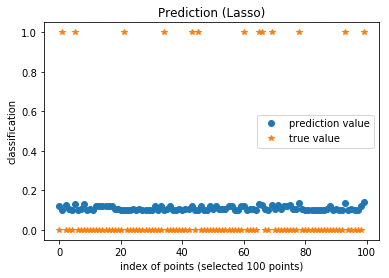

In [263]:
## plot classification
plt.plot(np.linspace(0,99,100),clf.predict(x_testing)[0:100],'o',label="prediction value")
plt.plot(np.linspace(0,99,100),y_testing[0:100],'*',label="true value")
plt.legend(loc=0)
#,y_testing
plt.title("Prediction (Lasso)")
plt.xlabel('index of points (selected 100 points)')
plt.ylabel('classification')

#### Lasso Model is not suitable to be applied on this dataset

##  ridge regression l2,l2

In [184]:
model_ridge = linear_model.Ridge(alpha=1)
model_ridge.fit(x_training, y_training)
model_ridge.coef_
print("Training accuracy: ", model_ridge.score(x_training, y_training))


model_select=np.zeros((20,2))
tmp=0
lamda=0
j=0
for i in np.linspace(0.5,9.5,10):
    clf = linear_model.Ridge(alpha=i)#0.5-5.0
    model_select[int(j),0]=i
    model_select[int(j),1]=np.mean(cross_val_score(clf,x_training,y_training,cv=10))
    if model_select[int(j),1]>tmp:
        tmp= model_select[int(j),1]
        lamda=i    
    print i,'  ',model_select[int(j),1]
    j+=1
print "Best_ridge:\nLambda=",lamda,"\naccuracy=",tmp


('Training accuracy: ', 0.21166774950389744)
0.5    0.208652936684
1.5    0.208666731548
2.5    0.2086759949
3.5    0.208681458069
4.5    0.208683688666
5.5    0.208683140956
6.5    0.208680181879
7.5    0.208675111568
8.5    0.208668178763
9.5    0.208659592191
Best_Logistic:
Lambda= 4.5 
accuracy= 0.208683688666


In [224]:
model_ridge = linear_model.Ridge(alpha=4.5)
model_ridge.fit(x_training, y_training)
print "Training Accuracy:", model_ridge.score(x_training, y_training)
print "Coefficients:", model_ridge.coef_
print x_training.columns.values
# test the model
model_ridge.predict(x_testing)
#print [np.copy(y_testing),model.predict(x_testing_ed)]
print("Testing accuracy: ", model_ridge.score(x_testing, y_testing))



Training Accuracy: 0.2116430714
Coefficients: [ -1.02371023e-02  -1.14062027e-02   2.43136316e-04   1.53272381e-03
  -9.81795126e-03   2.80883622e-02  -5.08196167e-03  -1.35677303e-02
  -6.59561460e-04  -4.69159581e-03   2.55978833e-02  -1.90069284e-05
   4.41798146e-03  -4.39897453e-03  -2.13768915e-02  -1.87373998e-02
  -1.21429774e-02  -2.57023449e-02  -1.96116468e-02  -1.36206338e-02
   1.11191894e-01  -3.62943978e-02   3.62943978e-02  -7.48067082e-02
  -1.19152248e-01  -1.34030901e-02   5.72662496e-02  -4.40795075e-03
  -7.57467675e-02   5.04362411e-02   2.33873161e-01  -4.73947251e-02
  -6.66416248e-03  -1.76008728e-02  -7.77993494e-05   1.03443154e-02
   5.69233746e-03   1.64201929e-03   4.10500074e-02   3.57435727e-01
  -1.37551742e-02  -1.64503950e-02  -3.14261739e-03   5.53605798e-04
   1.06509997e-03  -5.58820512e-03  -6.33743848e-03  -3.22296731e-01
   1.61875439e-01   2.19304179e-02   1.05873831e-01   1.91228627e-02
   0.00000000e+00]
['housemaid' 'services' 'admin.' 'tech

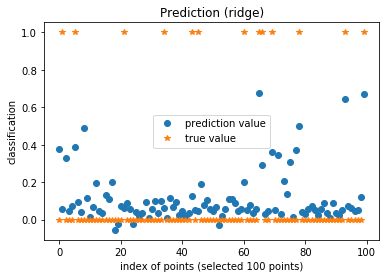

In [229]:
## plot classification
plt.plot(np.linspace(0,99,100),model_ridge.predict(x_testing)[0:100],'o',label="prediction value")
plt.plot(np.linspace(0,99,100),y_testing[0:100],'*',label="true value")
plt.legend(loc=0)
#,y_testing
plt.title("Prediction (ridge)")
plt.xlabel('index of points (selected 100 points)')
plt.ylabel('classification')

# Fit logistic regression model (logistic,l1)

###### Fit logistic regression model
model = LogisticRegression(penalty='l1', C=1, multi_class='ovr')
model.fit(x_training, y_training)
print("Training accuracy: ", model.score(x_training, y_training))
model_select=np.zeros((20,2))
tmp=0
lamda=0
j=0
for i in np.linspace(0.5,3,6):
    clf = LogisticRegression(penalty='l1', C=i, multi_class='ovr')#0-3.0
    model_select[int(j),0]=i
    model_select[int(j),1]=np.mean(cross_val_score(clf,x_training,y_training,cv=10))
    if model_select[int(j),1]>tmp:
        tmp= model_select[int(j),1]
        lamda=i    
    print i,'  ',model_select[int(j),1]
    j+=1
print "Best_Logistic:\nLambda=",lamda,"\naccuracy=",tmp

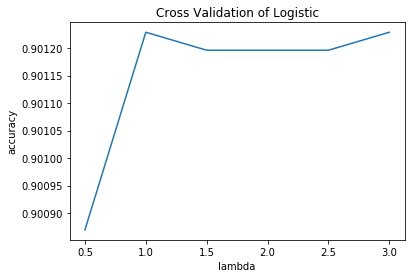

In [203]:
## cross validation (choose lambda)
plt.plot(model_select[0:6,0],model_select[0:6,1])
plt.title("Cross Validation of Logistic")
plt.xlabel('lambda')
plt.ylabel('accuracy')

In [268]:
#  Logistic Regression Model (find unefficient features)
model = LogisticRegression(penalty='l1', C=1, multi_class='ovr')
model.fit(x_training, y_training)
print "Coefficients:", model.coef_
print x_training.columns.values
print("Training accuracy: ", model.score(x_training, y_training))

Coefficients: [[-0.08197361 -0.13975649  0.02172812  0.02768696 -0.12740466  0.25810148
  -0.02704632 -0.11606249  0.         -0.02952481  0.18610773 -0.04425631
   0.         -0.10218555 -0.10746855 -0.05176064  0.0364847  -0.16247781
  -0.05127713  0.          0.79979205 -0.76142797  0.         -0.5098208
  -0.79535761 -0.08554916  0.29154253  0.         -0.60394419  0.19945122
   1.36023023 -0.18919623  0.07166533 -0.26906084 -0.05988012  0.07122678
   0.         -0.04214043  0.42980709  1.82472685 -0.26276737  0.
  -0.04704455  0.          0.00472691 -0.1224928  -0.02918578 -2.29590202
   1.20299583  0.14279844  0.32722472  0.47156075 -1.18026295]]
['housemaid' 'services' 'admin.' 'technician' 'blue-collar' 'retired'
 'management' 'unemployed' 'self-employed' 'entrepreneur' 'student'
 'married' 'single' 'divorced' 'basic.4y' 'high.school' 'basic.6y'
 'basic.9y' 'professional.course' 'university.degree' 'illiterate'
 'telephone' 'cellular' 'may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' '

According to the result from best Logistic Model, some features are of low correlation with classification. Thus, we prefer to remove them form the model, Such as 'loan' and so on. Though the coefficents of some of dummy variables (first 41 features in the list) are also 0, we cannot remove them, because they are generated by one-hot encoding.

In [212]:
# Test Logistic Regression Model (drop 'euribor3m', 'nr.employed',...)
#x_training_ed=x_training.drop(["euribor3m","nr.employed","loan", 'age','default'],axis=1)
x_training_ed=x_training.drop("loan",axis=1)
model = LogisticRegression(penalty='l1', C=0.5, multi_class='ovr')
model.fit(x_training_ed, y_training)
print "Training Accuracy:", model.score(x_training_ed, y_training)
print "Coefficients:", model.coef_
print x_training_ed.columns.values
# test the model
x_testing_ed=x_testing.drop(["loan"],axis=1)
model.predict(x_testing_ed)
print [np.copy(y_testing),model.predict(x_testing_ed)]
print("Testing accuracy: ", model.score(x_testing_ed, y_testing))

Training Accuracy: 0.901392338868
Coefficients: [[-0.05013891 -0.12234969  0.03421606  0.03465708 -0.11097961  0.26948635
  -0.00750776 -0.08909387  0.          0.          0.1893471  -0.04253681
   0.         -0.09742851 -0.10445239 -0.04995784  0.02542936 -0.15907323
  -0.04453742  0.          0.1550671  -0.73075014  0.         -0.48268155
  -0.64905425 -0.01516293  0.28270522  0.         -0.56148867  0.16364967
   1.32766497 -0.1262247   0.01585395 -0.26591893 -0.05702418  0.06936571
   0.         -0.03681405  0.41589455  1.81120097 -0.25971385  0.
  -0.04649342  0.0044729  -0.12179254 -0.03027071 -2.09539885  1.06876612
   0.12990282  0.37907375  0.2966676  -0.51689204]]
['housemaid' 'services' 'admin.' 'technician' 'blue-collar' 'retired'
 'management' 'unemployed' 'self-employed' 'entrepreneur' 'student'
 'married' 'single' 'divorced' 'basic.4y' 'high.school' 'basic.6y'
 'basic.9y' 'professional.course' 'university.degree' 'illiterate'
 'telephone' 'cellular' 'may' 'jun' 'jul' 'a

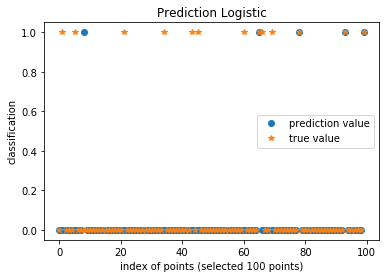

In [223]:
## plot classification
plt.plot(np.linspace(0,99,100),model.predict(x_testing_ed)[0:100],'o',label="prediction value")
plt.plot(np.linspace(0,99,100),y_testing[0:100],'*',label="true value")
plt.legend(loc="right")
#,y_testing
plt.title("Prediction Logistic")
plt.xlabel('index of points (selected 100 points)')
plt.ylabel('classification')

Though we discard some of the features and fit the model again, the accuracy of the model is stable (testing accuracy is 0.90), which justifies our revision.

## SVM

In [192]:
# SVM cross-validation
from sklearn import svm
model_select=np.zeros((6,2))
tmp=0
lamda=0
j=0
for i in np.linspace(0.5,3,6):
    clf = svm.SVC(kernel='linear', C=i)#choose penalty parameter within 0.1-3.0
    model_select[j,0]=i
    model_select[j,1]=np.mean(cross_val_score(clf,x_training,y_training,cv=3))
    if model_select[j,1]>tmp:
        tmp= model_select[j,1]
        lamda=i
    print i,'  ',model_select[j,1]
    j=j+1
print "Best_SVM:\nLambda=",lamda,"\naccuracy=",tmp


In [264]:
# Test SVM Model
model = svm.SVC(kernel='linear', C=0.5)
model.fit(x_training, y_training)
print("training accuracy: ", model.score(x_training, y_training))
print("Testing accuracy: ", model.score(x_testing, y_testing))

('training accuracy: ', 0.89913714211007978)
('Testing accuracy: ', 0.89423454046280559)


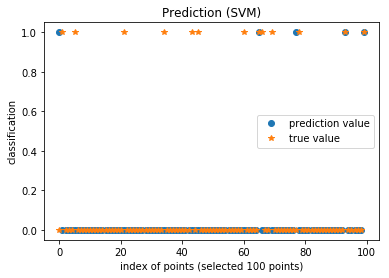

In [233]:
## plot classification
plt.plot(np.linspace(0,99,100),model.predict(x_testing)[0:100],'o',label="prediction value")
plt.plot(np.linspace(0,99,100),y_testing[0:100],'*',label="true value")
plt.legend(loc=0)
#,y_testing
plt.title("Prediction (SVM)")
plt.xlabel('index of points (selected 100 points)')
plt.ylabel('classification')

## single decision tree

In [244]:
# Fit a single decision tree
model_select=np.zeros((16,3))
tmp=0
lamda=0
j=0
for i in np.linspace(5,20,16):#check max depth from 5-20
    model = DecisionTreeClassifier(max_features=None, max_depth=int(i))#0.1-2.0
    model.fit(x_training_DT, y_training_DT)
    model_select[j,0]=int(i)
    model_select[j,1]=model.score(x_training_DT, y_training_DT)
    if j>0:
        model_select[j,2]=model_select[j,1]-model_select[j-1,1]
    if model_select[j,1]>tmp:
        tmp= model_select[j,1]
        max_depth=i
    print i,'  ',model_select[j,1],'  ',model_select[j,2]
    j+=1      
        
print "Best_DT:\nmax_depth=",max_depth,"\naccuracy=",tmp

5.0    0.904039743757    0.0
6.0    0.905216368153    0.00117662439535
7.0    0.906981304746    0.00176493659302
8.0    0.909661393646    0.00268008890051
9.0    0.913485422931    0.00382402928487
10.0    0.917570924304    0.00408550137273
11.0    0.921983265786    0.00441234148255
12.0    0.926983919467    0.00500065368022
13.0    0.931951889136    0.00496796966924
14.0    0.936723754739    0.00477186560335
15.0    0.942606876716    0.00588312197673
16.0    0.947542162374    0.00493528565826
17.0    0.95440580468    0.00686364230618
18.0    0.960256242646    0.00585043796575
19.0    0.966400836711    0.00614459406458
20.0    0.972480062753    0.00607922604262
Best_DT:
max_depth= 20.0 
accuracy= 0.972480062753


In [265]:
# Test DT Model
model = DecisionTreeClassifier(max_features=None, max_depth=17)
model.fit(x_training_DT, y_training_DT)
print("training accuracy: ", model.score(x_training_DT, y_training_DT))
print("Testing accuracy: ", model.score(x_testing_DT, y_testing_DT))

('training accuracy: ', 0.95450385671329585)
('Testing accuracy: ', 0.87593149431298212)


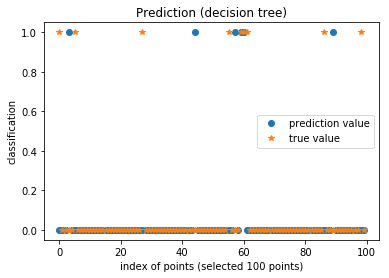

In [250]:
## plot classification
plt.plot(np.linspace(0,99,100),model.predict(x_testing_DT)[0:100],'o',label="prediction value")
plt.plot(np.linspace(0,99,100),y_testing_DT[0:100],'*',label="true value")
plt.legend(loc=0)
#,y_testing
plt.title("Prediction (decision tree)")
plt.xlabel('index of points (selected 100 points)')
plt.ylabel('classification')

### plot decision tree

In [ ]:
model_DT = DecisionTreeClassifier(max_features=None, max_depth=5)
model_DT.fit(x_training_DT, y_training_DT)
print("Training accuracy: ", model_DT.score(x_training_DT, y_training_DT))
print("Testing accuracy: ", model_DT.score(x_testing_DT, y_testing_DT))


from IPython.display import Image 
import graphviz 
from sklearn import tree
Feature_names=['housemaid','services','admin.','technician','blue-collar','unemployed','retired','entrepreneur','management','student','self-employed','married','single','divorced','basic.4y','high.school','basic.6y'
,'professional.course','basic.9y','university.degree','illiterate','telephone','cellular','may','jun','jul','aug','oct','nov','dec','mar','apr','sep','mon','tue','wed','thu','fri','poutcome.nonexistent','failure'
,'success','default','housing','loan','age','campaign','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
Class_names=['0','1']
dot_data = tree.export_graphviz(model_DT, out_file=None,feature_names=Feature_names,class_names=Class_names,filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [76]:
model_DT = DecisionTreeClassifier(max_features=None, max_depth=17)
model_DT.fit(x_training_DT, y_training_DT)
print("Training accuracy: ", model_DT.score(x_training_DT, y_training_DT))
print("Testing accuracy: ", model_DT.score(x_testing_DT, y_testing_DT))


('Training accuracy: ', 0.97015292525931696)
('Testing accuracy: ', 0.84320157454485811)


In [223]:
base_model = DecisionTreeClassifier(max_features=None, max_depth=20)
model = BaggingClassifier(base_estimator=base_model, n_estimators=50)
model.fit(x_training, y_training)
print("Training accuracy: ", model.score(x_training, y_training))


('Training accuracy: ', 0.99967202361429974)


# Random Forest

In [256]:
# Fit a single decision tree
model_select=np.zeros((16,3))
tmp=0
lamda=0
acc=0
j=0
for i in np.linspace(5,20,16):#check max depth from 5-20
    model = RandomForestClassifier(n_estimators=10, max_depth=i, max_features='auto')#0.1-2.0
    model.fit(x_training_DT, y_training_DT)
    model_select[j,0]=int(i)
    model_select[j,1]=model.score(x_training_DT, y_training_DT)
    if j>0:
        model_select[j,2]=model_select[j,1]-model_select[j-1,1]
    if model_select[j,2]>tmp:
        tmp= model_select[j,2]
        acc=model_select[j,1]
        max_depth=i
    print i,'  ',model_select[j,1],'  ',model_select[j,2]
    j+=1      
        
print "Best_DT:\nmax_depth=",max_depth,"\naccuracy=",acc

5.0    0.900705974637    0.0
6.0    0.902405543208    0.00169956857106
7.0    0.905641260295    0.0032357170872
8.0    0.907569616943    0.00192835664793
9.0    0.911524382272    0.0039547653288
10.0    0.915511831612    0.00398744933978
11.0    0.920251013204    0.00473918159236
12.0    0.923878938423    0.00362792521898
13.0    0.930513792653    0.00663485422931
14.0    0.932278729246    0.00176493659302
15.0    0.935939338476    0.00366060922996
16.0    0.940874624134    0.00493528565826
17.0    0.946006013858    0.00513138972415
18.0    0.947803634462    0.001797620604
19.0    0.954013596549    0.00620996208655
20.0    0.958981566218    0.00496796966924
Best_DT:
max_depth= 13.0 
accuracy= 0.930513792653


In [257]:
# Fit random forest
modelrf = RandomForestClassifier(n_estimators=10, max_depth=13, max_features='auto')
modelrf.fit(x_training_DT, y_training_DT)
print("Training accuracy: ", modelrf.score(x_training_DT, y_training_DT))
print("Testing accuracy: ", modelrf.score(x_testing_DT, y_testing_DT))

('Training accuracy: ', 0.92838933193881557)
('Testing accuracy: ', 0.89920251013204344)


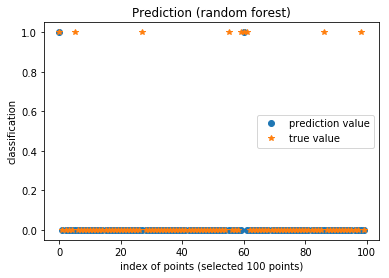

In [259]:
## plot classification
plt.plot(np.linspace(0,99,100),modelrf.predict(x_testing_DT)[0:100],'o',label="prediction value")
plt.plot(np.linspace(0,99,100),y_testing_DT[0:100],'*',label="true value")
plt.legend(loc=0)
#,y_testing
plt.title("Prediction (random forest)")
plt.xlabel('index of points (selected 100 points)')
plt.ylabel('classification')

In [66]:
# Fit boosted model
base_model = DecisionTreeClassifier(max_features='auto', max_depth=30)
#base_model = LogisticRegression(penalty='l2', C=10, multi_class='ovr')
model = AdaBoostClassifier(base_estimator=base_model, n_estimators=10)
model.fit(x_training_DT, y_training_DT)
print("Training accuracy: ", model.score(x_training_DT, y_training_DT))
print("Testing accuracy: ", model.score(x_testing_DT, y_testing_DT))

('Training accuracy: ', 0.99401418556024768)
('Testing accuracy: ', 0.84812202722650487)
